In [1]:
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph,VectorField
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [2]:
# Successive Over-Relaxation (SOR) method to solve Laplace equation
# so fasttttt
#from pylab import imshow,gray,show
import matplotlib.pyplot as plt
import numpy as np

#set up grid
nx,ny = 100,100
x = np.linspace(0, nx, nx + 1)
y = np.linspace(0, ny, ny + 1)
X, Y = np.meshgrid(x, y)
L = 1
delta = L/nx


#charge density
rho = np.zeros([nx+1,ny+1],float)
rho[40:60,:] = 1e12* (1.6e-19) #C/m^2
epsilon = 8.85e-12 #F/m

#time steps
steps = 100
time_step = 1e-1

#magnetic field
B = 0.1 #Tesla

In [ ]:
def solve_Poisson(rho, w=1.8, threshold=1e-2):
    phi_ori = np.zeros([nx+1, ny+1], float)
    phi_pred = np.zeros([nx+1, ny+1], float)
    phi_new = np.zeros([nx+1, ny+1], float)

    phi_ori[0,:] = 0
    phi_ori[nx,:] =0
    phi_ori[:,0] = phi_ori[:,ny]
    diff = 1
    iteration = 0

    while diff > threshold:
        for i in range (1,nx):
            for j in range (ny+1):
                if  j==0 or j ==100:
                    phi_pred[i,j] =  1/4*(phi_new[i+1,j]+phi_new[i-1,j]+phi_new[i,(j+1)%(ny+1)]+phi_new[i,(j-1)%(ny+1)]-rho[i,j]/epsilon*delta)
                    phi_new[i,j] = (1-w)*phi_ori[i,j] + w*phi_pred[i,j]
                else:
                    phi_pred[i,j]= 1/4*(phi_new[i+1,j]+phi_new[i-1,j]+phi_new[i,j+1]+phi_new[i,j-1]-rho[i,j]/epsilon*delta)
                    phi_new[i,j] = (1-w)*phi_ori[i,j] + w*phi_pred[i,j]


        diff = np.max(abs(phi_new - phi_ori))
        phi_ori = phi_new.copy()
        iteration += 1

        if iteration % 500 == 0:
            print(f"Iteration: {iteration}, Max Difference: {diff:.2e}")

    return phi_new, iteration

def electric_field(phi):
    Ex = np.zeros([nx+1, ny+1], float)
    Ey = np.zeros([nx+1, ny+1], float)

    for i in range(1, nx):
        for j in range(1, ny):
            #row of an array is 'i' (y-direction)
            #column of an array is 'j' (x-direction)
            Ex[i, j] = -(phi[i, j + 1] - phi[i, j - 1]) / (2*delta)
            Ey[i, j] = -(phi[i + 1, j] - phi[i - 1, j]) / (2*delta)


    plt.show()
    return Ex, Ey

def velocity(Ex, Ey, B):
    vx = np.zeros([nx+1, ny+1], float)
    vy = np.zeros([nx+1, ny+1], float)

    for i in range(1, nx):
        for j in range(1, ny):
            vx[i, j] = Ey[i, j] / B
            vy[i, j] = -Ex[i, j] / B

    return vx, vy

#method of lines: turning PDE into ODE
def charge_density_ode(time_span, rho, vx, vy):
    rho= rho.reshape((nx+1, ny+1))
    dndt = np.zeros_like(rho)
    #dndt[0, :] = 0
    #dndt[nx, :] = 0
       
    for i in range(1, nx):
        for j in range(1, ny):
            dndt[i, j] = - ( (rho[i + 1, j] * vx[i + 1, j] - rho[i - 1, j] * vx[i - 1, j]) / (2 * delta) +
                             (rho[i, j + 1] * vy[i, j + 1] - rho[i, j - 1] * vy[i, j - 1]) / (2 * delta) )
    return dndt.flatten()


def charge_density_pde(rho, vx, vy, time_step):
    grid = CartesianGrid([[0, L], [0, L]], [nx, ny])
    field = ScalarField(grid, rho[0:nx, 0:ny])  # Exclude boundaries for PDE solver
    velocity_field= VectorField(grid, vx,vy)
    # Define the PDE
    pde = PDE({"rho": "-(rho * div(v))"},
              consts = {"v": velocity_field})

    # Time evolution
    storage = MemoryStorage()
    state = field
    for _ in range(1):  # Single time step
        state = pde.solve(state, t=0, dt=time_step, tracker=storage.tracker(1))

    rho_new = np.zeros([nx+1, ny+1], float)
    rho_new[0:nx, 0:ny] = state.data  # Update only the interior points

    return rho_new

Iteration: 500, Max Difference: 3.49e+01
Iteration: 1000, Max Difference: 3.75e+00
Iteration: 1500, Max Difference: 4.02e-01
Iteration: 2000, Max Difference: 4.31e-02


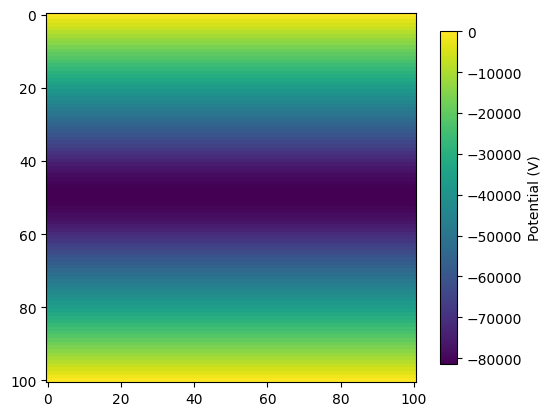

In [4]:
phi = solve_Poisson(rho)[0]
plt.imshow(phi)
plt.colorbar(label="Potential (V)",shrink=0.9)


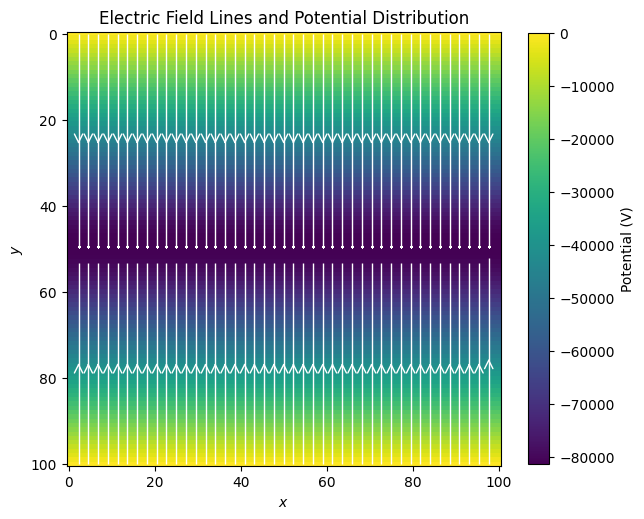

In [5]:
Ex, Ey = electric_field(phi)
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Electric Field Lines and Potential Distribution')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.streamplot(X, Y, Ex, Ey, color="white", linewidth=1, cmap=plt.cm.inferno,
              density=1.5, arrowstyle='->', arrowsize=1.5)


plt.imshow(phi)
plt.colorbar(label="Potential (V)",shrink=0.8)
plt.show()

In [9]:
def solve_rho_ode(vx,vy,rho):
    #vx, vy = velocity(Ex, Ey, B)
    time_span = (0.0, 0.01)
    time_intervals = np.linspace(0.0, 0.01,20)
    rho_0 = rho.flatten()
    sol = solve_ivp(charge_density_ode, time_span, rho_0, method='BDF', t_eval=time_intervals, args=(vx, vy))
    rho_new = sol.y[:,-1]
    return rho_new.reshape(nx+1, ny+1)

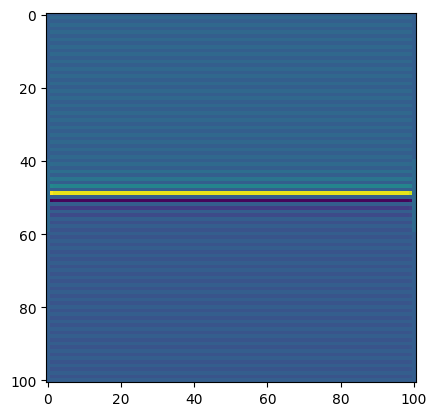

In [7]:
vx, vy = velocity(Ex, Ey, B)
time_span = (0.0, 0.01)
time_intervals = np.linspace(0.0, 0.01,20)
rho_0 = rho.flatten()
sol = solve_ivp(charge_density_ode, time_span, rho_0, method='BDF', t_eval=time_intervals, args=(vx, vy))
rho_new = sol.y[:,-1]
rho_update = rho_new.reshape(nx+1, ny+1)
plt.imshow(rho_update)
plt.show()

Iteration: 500, Max Difference: 3.49e+01
Iteration: 1000, Max Difference: 3.75e+00
Iteration: 1500, Max Difference: 4.02e-01
Iteration: 2000, Max Difference: 4.31e-02


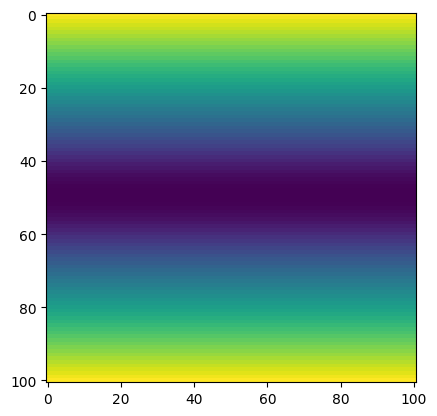

Time step 0


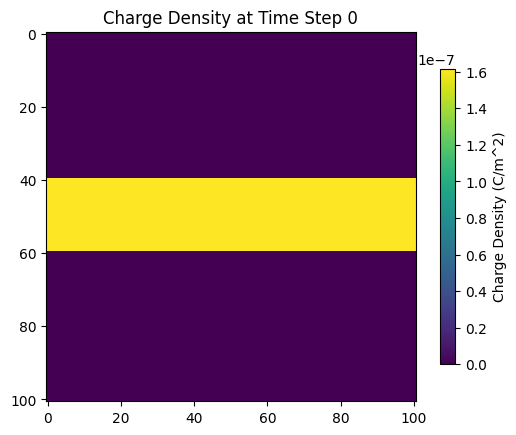

Iteration: 500, Max Difference: 3.53e+01
Iteration: 1000, Max Difference: 3.78e+00
Iteration: 1500, Max Difference: 4.06e-01
Iteration: 2000, Max Difference: 4.36e-02


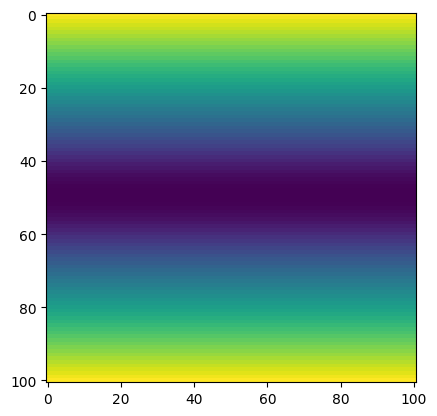

Iteration: 500, Max Difference: 3.56e+01
Iteration: 1000, Max Difference: 3.82e+00
Iteration: 1500, Max Difference: 4.10e-01
Iteration: 2000, Max Difference: 4.40e-02


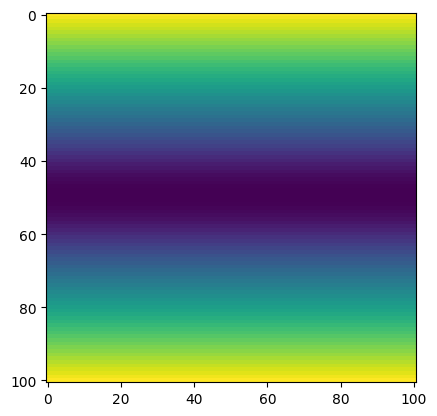

Iteration: 500, Max Difference: 3.60e+01
Iteration: 1000, Max Difference: 3.86e+00
Iteration: 1500, Max Difference: 4.14e-01
Iteration: 2000, Max Difference: 4.44e-02


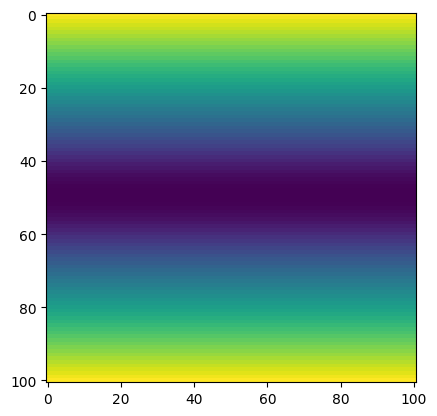

Iteration: 500, Max Difference: 3.63e+01
Iteration: 1000, Max Difference: 3.90e+00
Iteration: 1500, Max Difference: 4.18e-01
Iteration: 2000, Max Difference: 4.49e-02


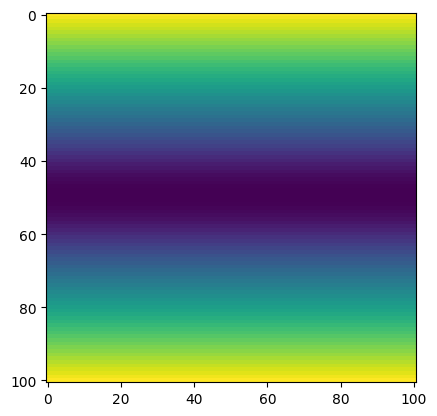

Iteration: 500, Max Difference: 3.67e+01
Iteration: 1000, Max Difference: 3.94e+00
Iteration: 1500, Max Difference: 4.22e-01
Iteration: 2000, Max Difference: 4.53e-02


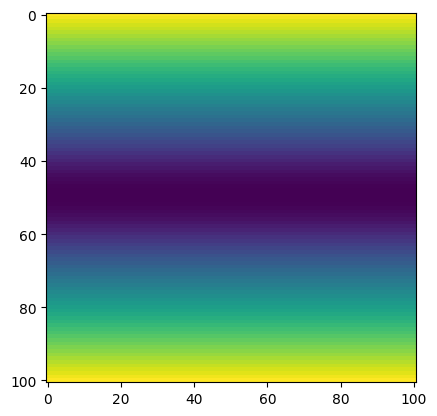

Iteration: 500, Max Difference: 3.71e+01
Iteration: 1000, Max Difference: 3.98e+00
Iteration: 1500, Max Difference: 4.27e-01
Iteration: 2000, Max Difference: 4.58e-02


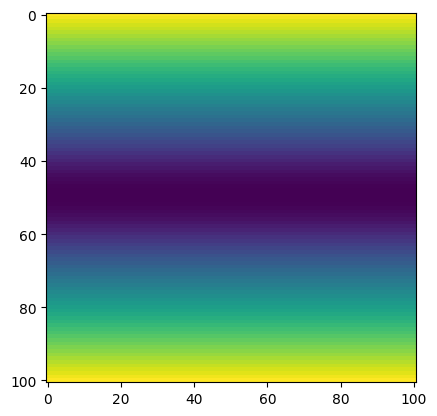

Iteration: 500, Max Difference: 3.74e+01
Iteration: 1000, Max Difference: 4.02e+00
Iteration: 1500, Max Difference: 4.31e-01
Iteration: 2000, Max Difference: 4.62e-02


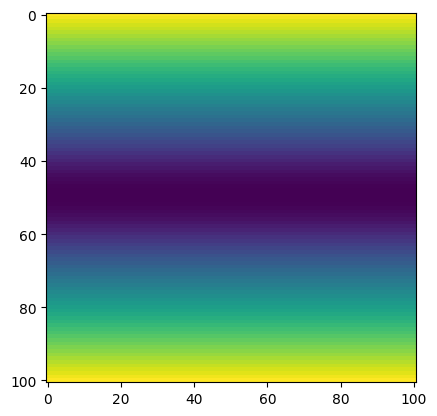

Iteration: 500, Max Difference: 3.78e+01
Iteration: 1000, Max Difference: 4.06e+00
Iteration: 1500, Max Difference: 4.35e-01
Iteration: 2000, Max Difference: 4.67e-02


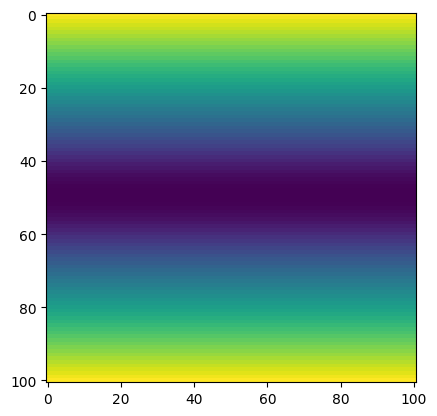

Iteration: 500, Max Difference: 3.82e+01
Iteration: 1000, Max Difference: 4.10e+00
Iteration: 1500, Max Difference: 4.40e-01
Iteration: 2000, Max Difference: 4.72e-02


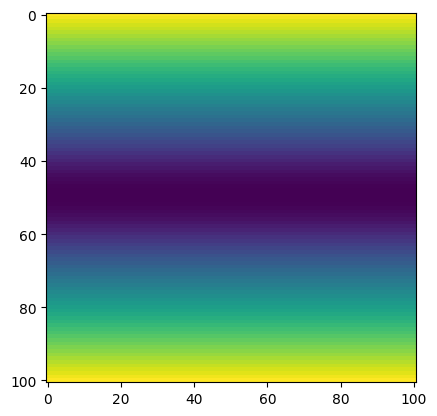

Iteration: 500, Max Difference: 3.86e+01
Iteration: 1000, Max Difference: 4.14e+00
Iteration: 1500, Max Difference: 4.44e-01
Iteration: 2000, Max Difference: 4.76e-02


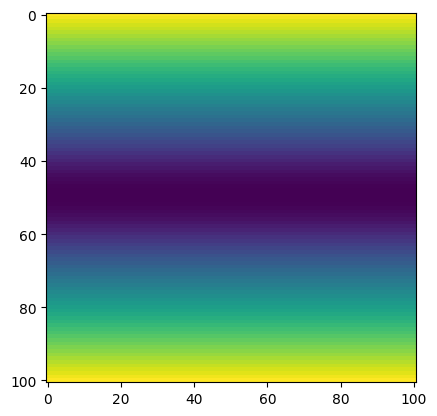

Time step 10


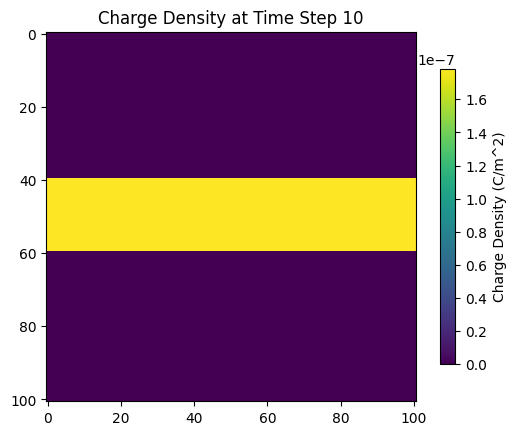

Iteration: 500, Max Difference: 3.90e+01
Iteration: 1000, Max Difference: 4.18e+00
Iteration: 1500, Max Difference: 4.48e-01
Iteration: 2000, Max Difference: 4.81e-02


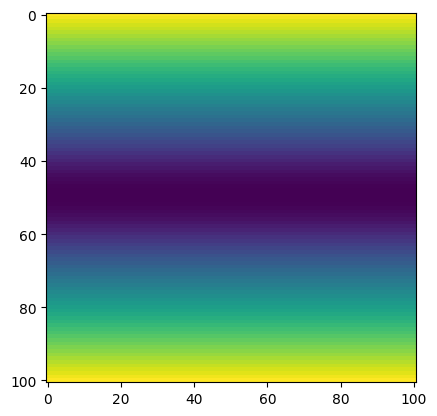

Iteration: 500, Max Difference: 3.93e+01
Iteration: 1000, Max Difference: 4.22e+00
Iteration: 1500, Max Difference: 4.53e-01
Iteration: 2000, Max Difference: 4.86e-02


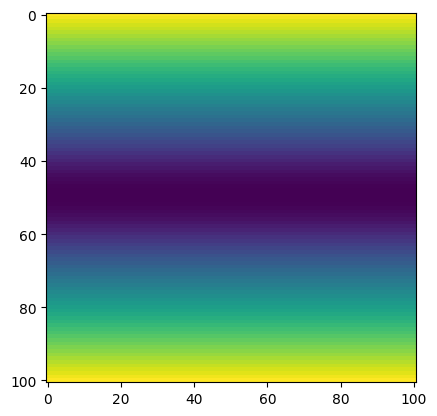

Iteration: 500, Max Difference: 3.97e+01
Iteration: 1000, Max Difference: 4.26e+00
Iteration: 1500, Max Difference: 4.57e-01
Iteration: 2000, Max Difference: 4.91e-02


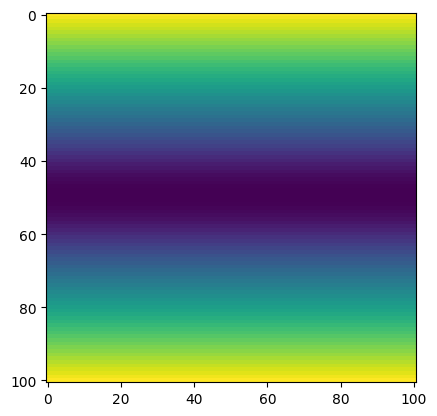

Iteration: 500, Max Difference: 4.01e+01
Iteration: 1000, Max Difference: 4.31e+00
Iteration: 1500, Max Difference: 4.62e-01
Iteration: 2000, Max Difference: 4.96e-02


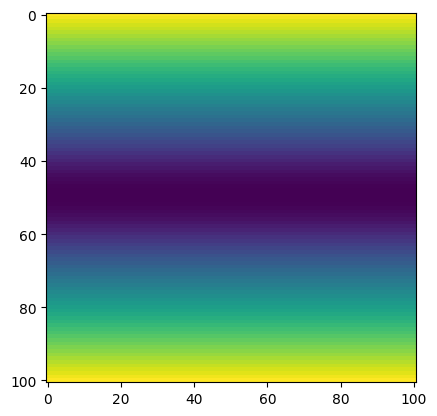

Iteration: 500, Max Difference: 4.05e+01
Iteration: 1000, Max Difference: 4.35e+00
Iteration: 1500, Max Difference: 4.67e-01
Iteration: 2000, Max Difference: 5.01e-02


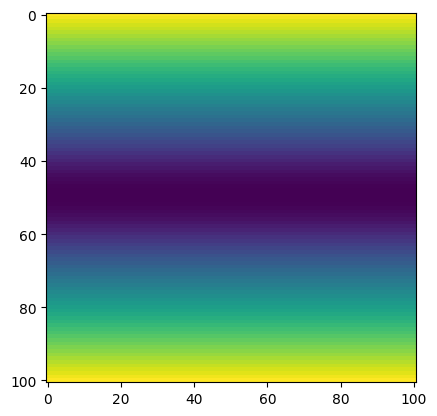

Iteration: 500, Max Difference: 4.09e+01
Iteration: 1000, Max Difference: 4.39e+00
Iteration: 1500, Max Difference: 4.71e-01
Iteration: 2000, Max Difference: 5.06e-02


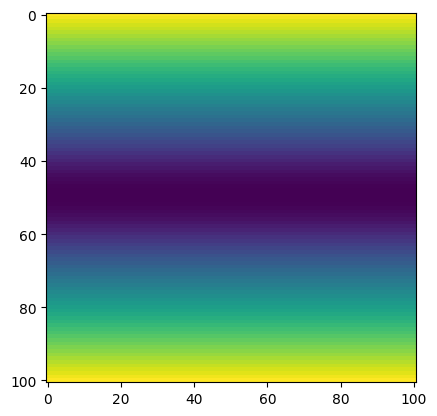

Iteration: 500, Max Difference: 4.13e+01
Iteration: 1000, Max Difference: 4.44e+00
Iteration: 1500, Max Difference: 4.76e-01
Iteration: 2000, Max Difference: 5.11e-02


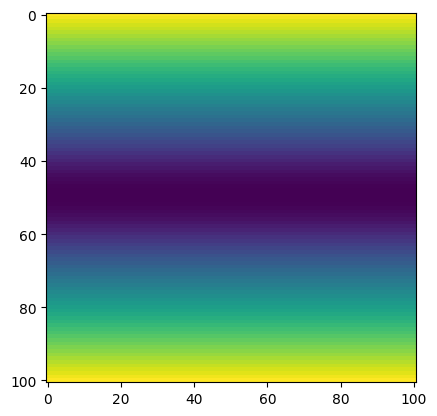

Iteration: 500, Max Difference: 4.18e+01
Iteration: 1000, Max Difference: 4.48e+00
Iteration: 1500, Max Difference: 4.81e-01
Iteration: 2000, Max Difference: 5.16e-02


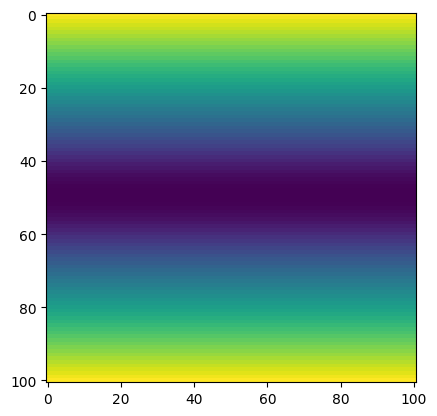

Iteration: 500, Max Difference: 4.22e+01
Iteration: 1000, Max Difference: 4.53e+00
Iteration: 1500, Max Difference: 4.86e-01
Iteration: 2000, Max Difference: 5.21e-02


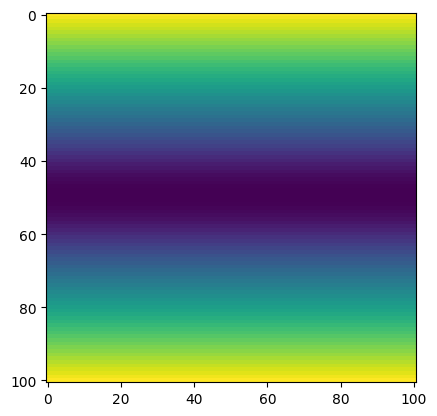

Iteration: 500, Max Difference: 4.26e+01
Iteration: 1000, Max Difference: 4.57e+00
Iteration: 1500, Max Difference: 4.90e-01
Iteration: 2000, Max Difference: 5.26e-02


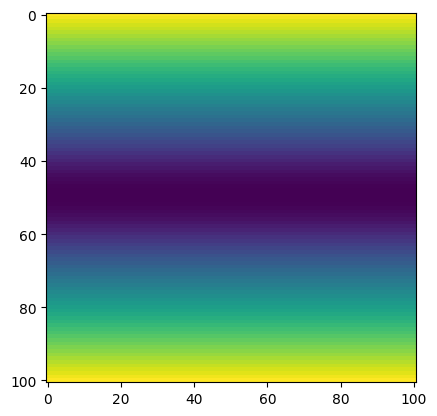

Time step 20


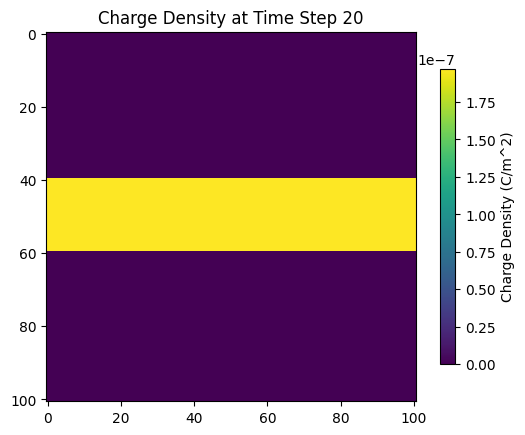

Iteration: 500, Max Difference: 4.30e+01
Iteration: 1000, Max Difference: 4.62e+00
Iteration: 1500, Max Difference: 4.95e-01
Iteration: 2000, Max Difference: 5.32e-02


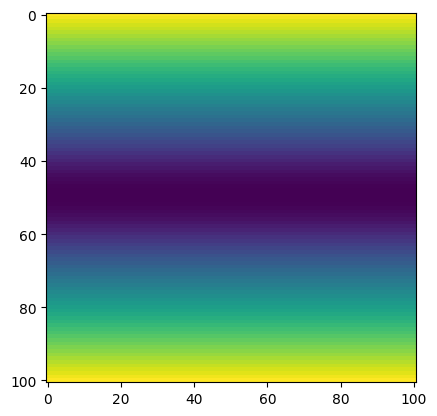

KeyboardInterrupt: 

In [ ]:
for i in range (steps):
    
    phi = solve_Poisson(rho)[0]
    Ex, Ey = electric_field(phi)
    vx, vy = velocity(Ex, Ey, B)
    rho_new = solve_rho_ode(vx,vy,rho)
    rho =  rho_new*time_step+ rho
    
    if i % 10 == 0:
        print(f"Time step {i}")
        plt.imshow(rho)
        plt.imshow(phi)
        plt.colorbar(label="Charge Density (C/m^2)",shrink=0.8)
        plt.title(f"Charge Density at Time Step {i}")
        plt.show()